<a href="https://colab.research.google.com/github/jdeepanshu/loan-msme/blob/main/loan_msme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
%matplotlib inline
plt.style.use("seaborn-darkgrid")
#Seting option for full column view of Data}
pd.set_option('display.max_columns', None)

<ipython-input-1-fcd49c326978>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


##Reading Data

In [2]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv")
display(df.head())
df.shape


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


(396030, 27)

##Helper Functions

In [3]:
#missing Values
def find_missing_values(df, all_columns=True):
    total_rows = len(df)
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / total_rows) * 100

    if all_columns:
        result_df = pd.DataFrame({
            'Column ': missing_percentage.index,
            'Count': missing_data.values,
            'Percentage': missing_percentage.values.round(2)
        })
    else:
        missing_mask = missing_percentage > 0
        result_df = pd.DataFrame({
            'Column': missing_percentage.index[missing_mask],
            'Count': missing_data.values[missing_mask],
            'Percentage': missing_percentage.values[missing_mask].round(2)
        })

    return result_df.sort_values(by='Percentage', ascending=False)


##Data info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [5]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.89,8357.44,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.64,4.47,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.85,250.73,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.18,61637.62,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.38,18.02,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.31,5.14,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.18,0.53,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.54,20591.84,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.79,24.45,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.41,11.89,2.00,17.00,24.00,32.00,151.00


In [6]:
df.describe(include="object").T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
issue_d,396030,115,Oct-2014,14846
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507


In [7]:
##Checking Duplicate Rows
duplicate_rows = df.duplicated()
duplicate_rows.sum()

0

##Extracting Data

In [8]:
#converting term values to numerical
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df['term'].map(term_values)

In [9]:
#Extracting city, state, postalcode from address
df["address"][:5]

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [10]:
df[['City', 'State', 'postal_code']] = df['address'].str.split().apply(lambda x: pd.Series([x[-3], x[-2], x[-1]]))
df=df.drop(["address"],axis = 1)

In [11]:
find_missing_values(df,False)

,Column,Count,Percentage
4,mort_acc,37795,9.54
0,emp_title,22927,5.79
1,emp_length,18301,4.62
2,title,1755,0.44
5,pub_rec_bankruptcies,535,0.14
3,revol_util,276,0.07


In [12]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

In [13]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'City',
 'State',
 'postal_code']

##EDA

In [14]:
df['loan_status'].value_counts(normalize=True).round(2)

Fully Paid     0.8
Charged Off    0.2
Name: loan_status, dtype: float64

In [15]:
#### Loan amount EDA
df.groupby(by = "loan_status")['loan_amnt'].describe().round(2).T

loan_status,Charged Off,Fully Paid
count,77673.00,318357.00
mean,15126.30,13866.88
std,8505.09,8302.32
min,1000.00,500.00
25%,8525.00,7500.00
50%,14000.00,12000.00
75%,20000.00,19225.00
max,40000.00,40000.00


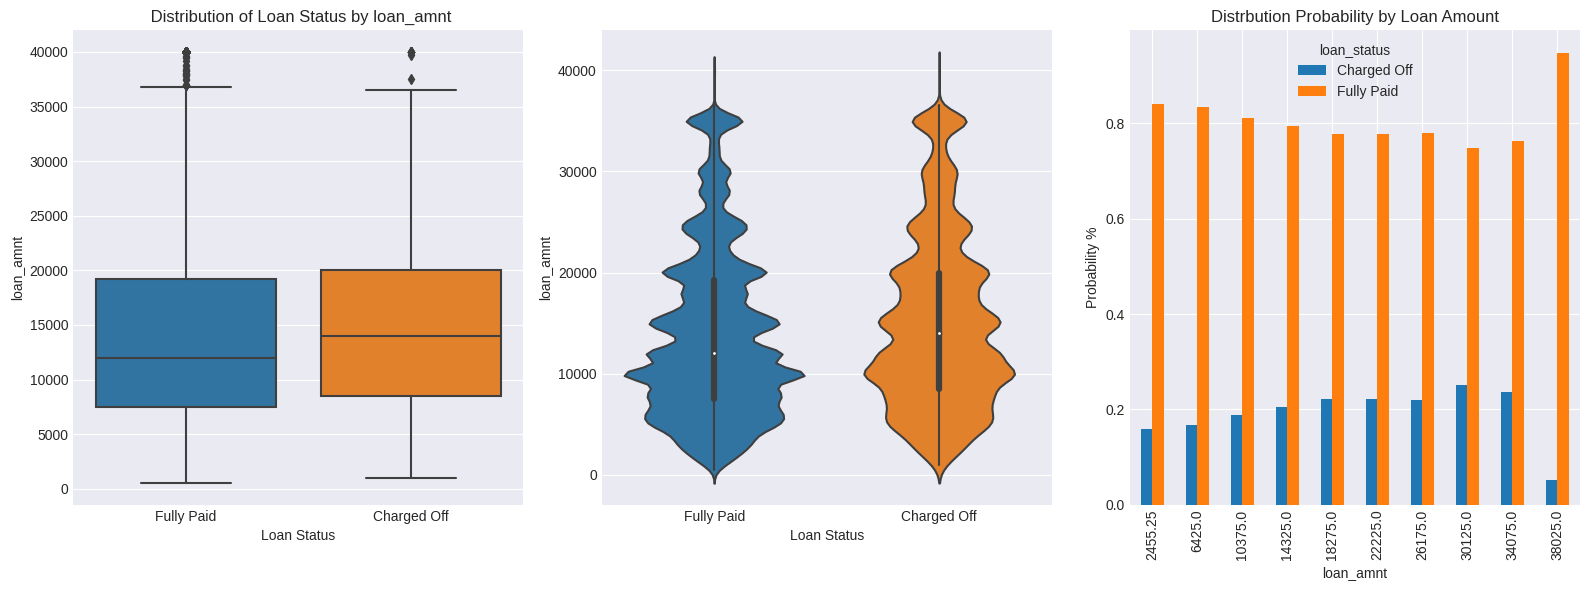

In [16]:
fig, axes = plt.subplots(1,3, figsize=(16,6))
item="loan_amnt"

sns.boxplot(data=df, x="loan_status", y=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)


sns.violinplot(data=df, x="loan_status", y=item, ax=axes[1])
# axes[1].set_title(" Distribution of Loan Status by "+ item )
axes[1].set_xlabel("Loan Status")
axes[1].set_ylabel(item)


pd.crosstab(index=pd.cut(df[item], bins=10).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[2])
axes[2].set_title("Distrbution Probability by Loan Amount")
axes[2].set_ylabel("Probability %")
# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()

Defaulters is higher than Fully Paid for ~16000 - 36000 Loan Amount



In [17]:
#### Loan Term
(pd.crosstab(index=df["term"],
            columns=df["loan_status"], normalize="index" , margins  = True
           ) * 100).round(2)

loan_status,Charged Off,Fully Paid
term,,
36,15.77,84.23
60,31.94,68.06
All,19.61,80.39


<Axes: xlabel='term'>

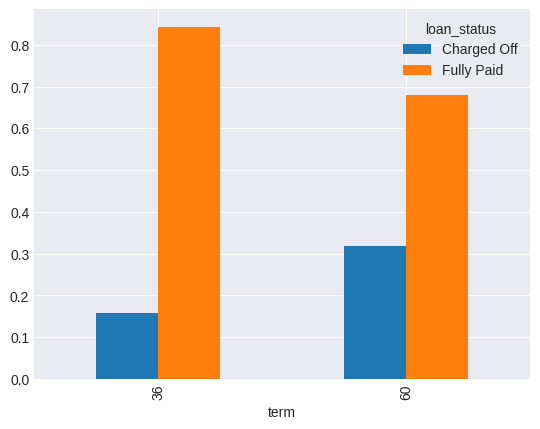

In [18]:
pd.crosstab(index=df['term'],
            columns =df["loan_status"], normalize="index"
           ).plot(kind = "bar")

Higher Term Loans have more defaulters than Fully Paid


In [19]:
### Int Rate

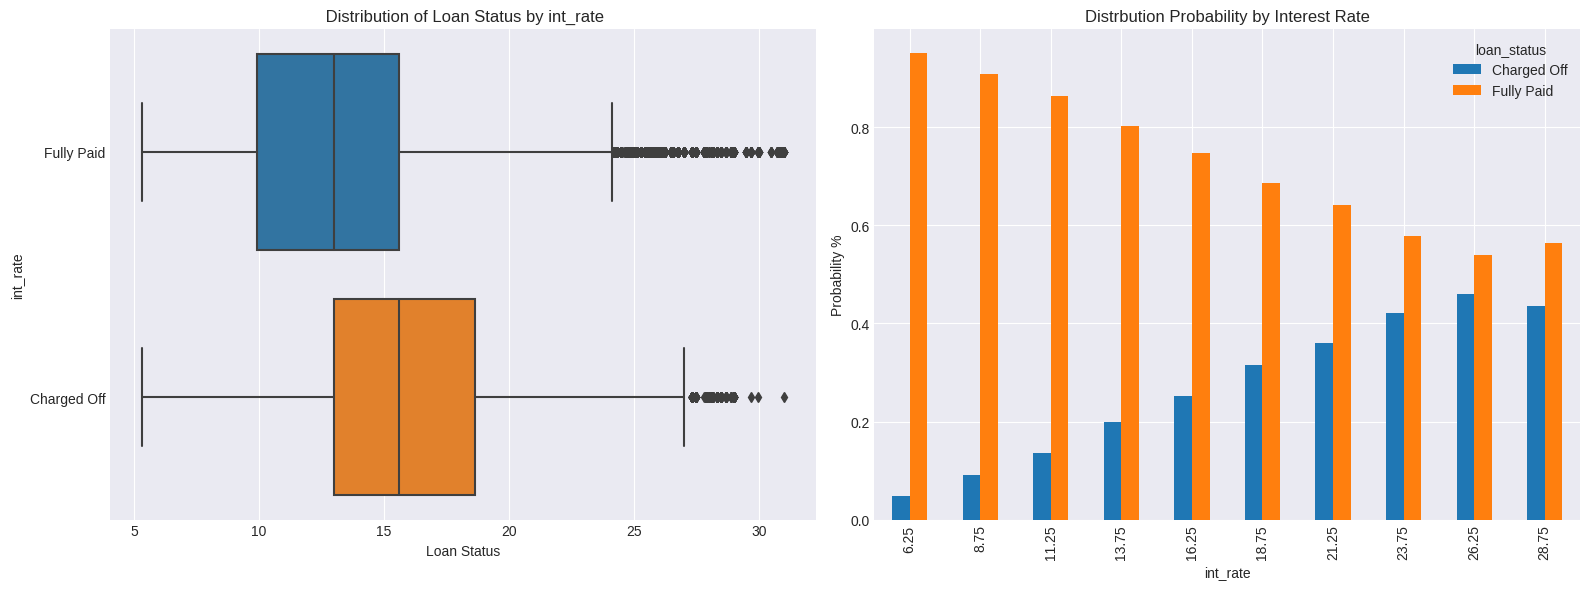

In [20]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="int_rate"
sns.boxplot(data=df, y="loan_status", x=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)

bins = pd.interval_range(start=round(df[item].min()), end=round(df[item].max()), freq=2.5)
pd.crosstab(index=pd.cut(df[item], bins=bins).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[1])
axes[1].set_title("Distrbution Probability by Interest Rate")
axes[1].set_ylabel("Probability %")
# Adjust the layout
plt.tight_layout()

# plt.title("Loan Status by "+ item )
plt.show()

In [21]:
df[df["loan_status"] == "Charged Off"]["int_rate"].median(),df[df["loan_status"] == "Charged Off"]["int_rate"].mean().round(2)

(15.61, 15.88)

In [22]:
df[df["loan_status"] == "Fully Paid"]["int_rate"].median(),df[df["loan_status"] == "Fully Paid"]["int_rate"].mean().round(2)

(12.99, 13.09)

Defaulter Loans also have Higher Interest Rate

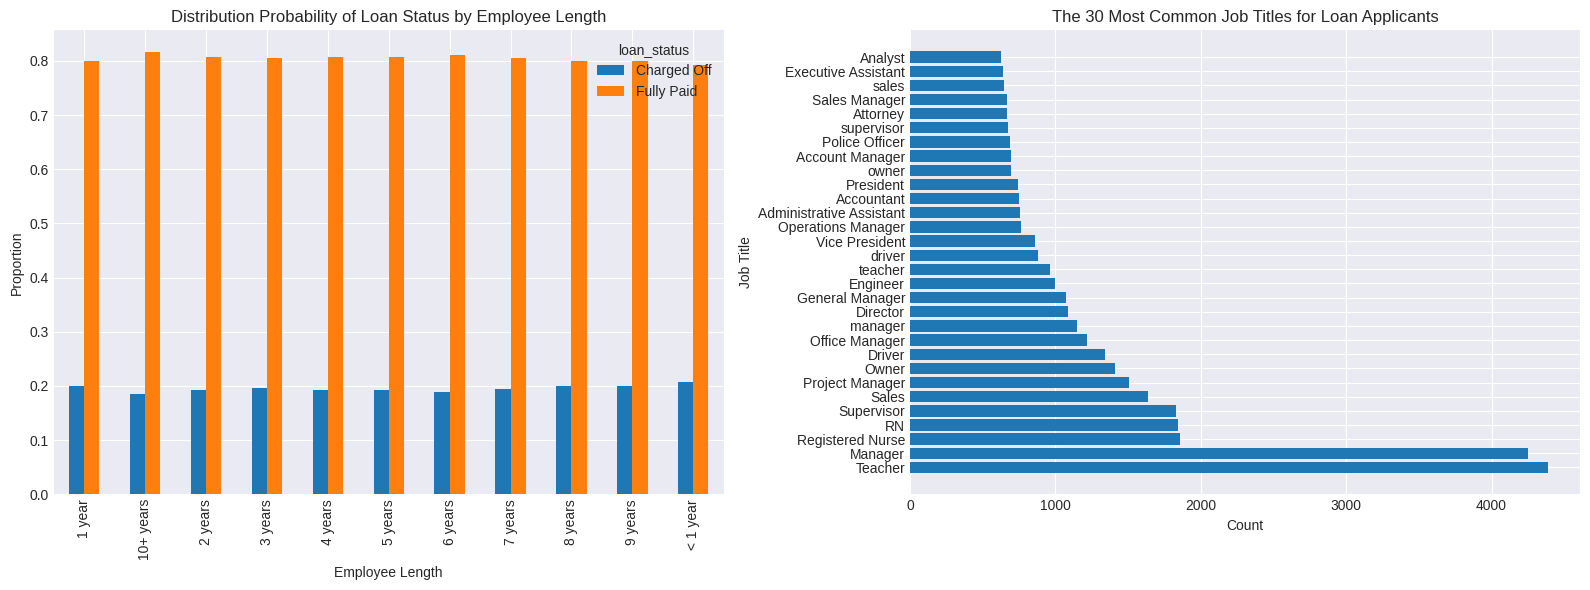

In [23]:
## Employee Title and Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of loan status by employee length
pd.crosstab(index=df["emp_length"], columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[0])
axes[0].set_title("Distribution Probability of Loan Status by Employee Length")
axes[0].set_xlabel("Employee Length")
axes[0].set_ylabel("Proportion")

# Horizontal bar plot of the 30 most common job titles
axes[1].barh(df['emp_title'].value_counts()[:30].index, df['emp_title'].value_counts()[:30])
axes[1].set_title("The 30 Most Common Job Titles for Loan Applicants")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Job Title")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()



*   Employement Length has overall same probability of Loan_status as fully paid as defaulters
*   Teacher and Manager are highest borrowed Employee Titles




In [24]:
## Loan Status by Verfication Status
result_verificationSt = (pd.crosstab(index=df["verification_status"], columns=df["loan_status"], normalize="index") * 100).round(2)
result_verificationSt.round(2)

loan_status,Charged Off,Fully Paid
verification_status,,
Not Verified,14.64,85.36
Source Verified,21.47,78.53
Verified,22.32,77.68


In [25]:
(pd.crosstab(index=df["verification_status"], columns=df["loan_status"], normalize="all",margins = True) * 100).round(2)

loan_status,Charged Off,Fully Paid,All
verification_status,,,
Not Verified,4.62,26.96,31.58
Source Verified,7.12,26.05,33.18
Verified,7.87,27.37,35.24
All,19.61,80.39,100.00


<Axes: xlabel='verification_status', ylabel='count'>

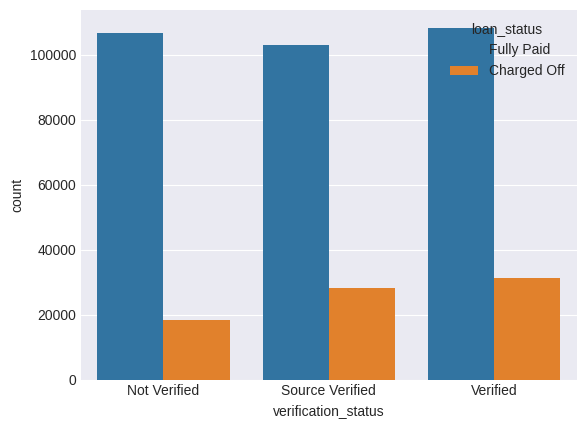

In [26]:
sns.countplot(x='verification_status',data=df,hue='loan_status')

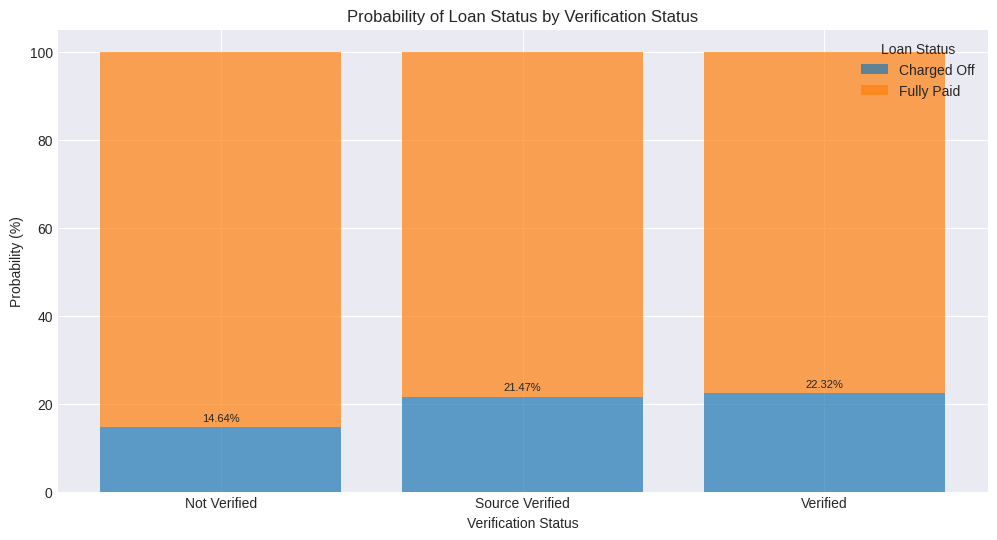

In [27]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_verificationSt["Charged Off"]
fully_paid_prob = result_verificationSt["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_verificationSt.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_verificationSt.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by Verification Status")
plt.xlabel("Verification Status")
plt.ylabel("Probability (%)")
plt.legend(title="Loan Status", loc='upper right')
plt.show()

In [28]:
### Loan Status by Purpose
result_purposeLoan =pd.crosstab(index = df["purpose"],
                               columns= df["loan_status"],normalize= "index", margins = True)*100
result_purposeLoan.round(2)

loan_status,Charged Off,Fully Paid
purpose,,
car,13.48,86.52
credit_card,16.71,83.29
debt_consolidation,20.74,79.26
educational,16.34,83.66
home_improvement,17.01,82.99
house,19.72,80.28
major_purchase,16.47,83.53
medical,21.71,78.29
moving,23.48,76.52


In [29]:
(pd.crosstab(index = df["purpose"],
            columns= df["loan_status"],normalize= "all", margins = True, margins_name='%Loans')*100).round(2).sort_values(by='%Loans', axis=0, ascending=False)

loan_status,Charged Off,Fully Paid,%Loans
purpose,,,
%Loans,19.61,80.39,100.00
debt_consolidation,12.28,46.93,59.21
credit_card,3.50,17.46,20.96
home_improvement,1.03,5.04,6.07
other,1.14,4.21,5.35
major_purchase,0.37,1.85,2.22
small_business,0.42,1.02,1.44
car,0.16,1.03,1.19
medical,0.23,0.83,1.06


*   Debt Consolidation are 60% of Loan Counts
*   Credit card ar 20% of Loan counts

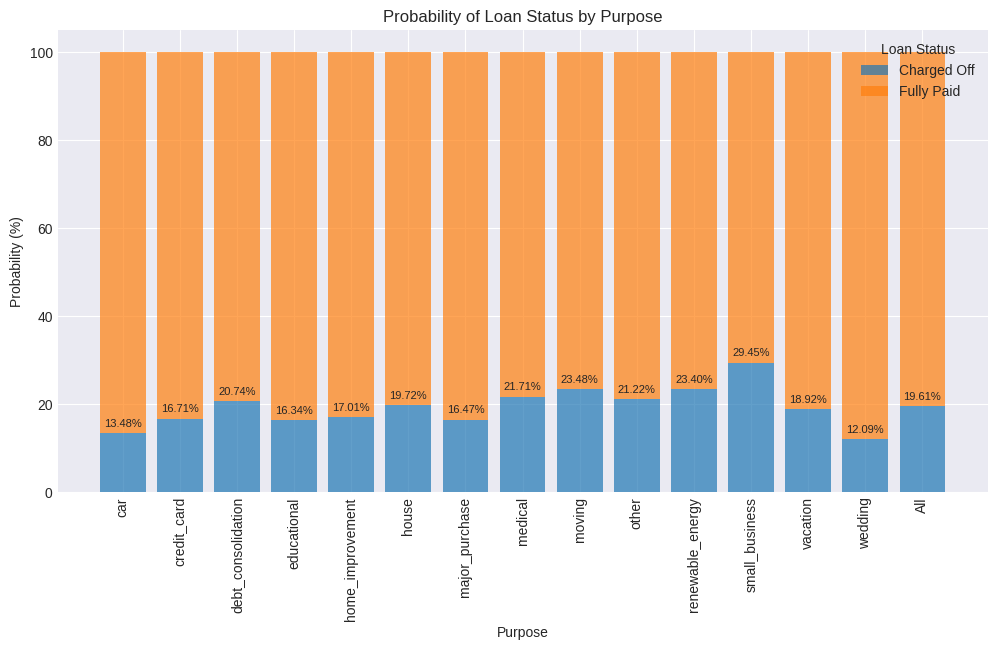

In [30]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_purposeLoan["Charged Off"]
fully_paid_prob = result_purposeLoan["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_purposeLoan.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_purposeLoan.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by Purpose")
plt.xlabel("Purpose")
plt.ylabel("Probability (%)")
plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()


*   Small Business have 30% Probabity of Default(Highest)
*   Car and Wedding Loans have 12-13.5% Proability of Default (Lowest
*   Debt Consolidation, Credit Card which are 80% of Purpose of Loans have 20,17% of Default Proability



In [31]:
### Public Rec Bankruptcies
(pd.crosstab(index = df["pub_rec_bankruptcies"],
            columns= df["loan_status"],normalize= "all", margins = True, margins_name='%Loans')*100).round(2)

loan_status,Charged Off,Fully Paid,%Loans
pub_rec_bankruptcies,,,
0.0,17.27,71.32,88.59
1.0,2.21,8.61,10.82
2.0,0.11,0.36,0.47
3.0,0.02,0.07,0.09
4.0,0.01,0.01,0.02
5.0,0.00,0.01,0.01
6.0,0.00,0.00,0.00
7.0,0.00,0.00,0.00
8.0,0.00,0.00,0.00


*   88% of Loans have 0 Public Record of Bankruptcies
*   11% of Loans have 1 Public Record of Bankruptcies

In [32]:
result_pub_rec_bankruptcies = (pd.crosstab(index=df["pub_rec_bankruptcies"], columns=df["loan_status"], normalize="index") * 100).round(2)
result_pub_rec_bankruptcies

loan_status,Charged Off,Fully Paid
pub_rec_bankruptcies,,
0.0,19.50,80.50
1.0,20.39,79.61
2.0,23.23,76.77
3.0,21.08,78.92
4.0,31.71,68.29
5.0,15.62,84.38
6.0,28.57,71.43
7.0,25.00,75.00
8.0,50.00,50.00


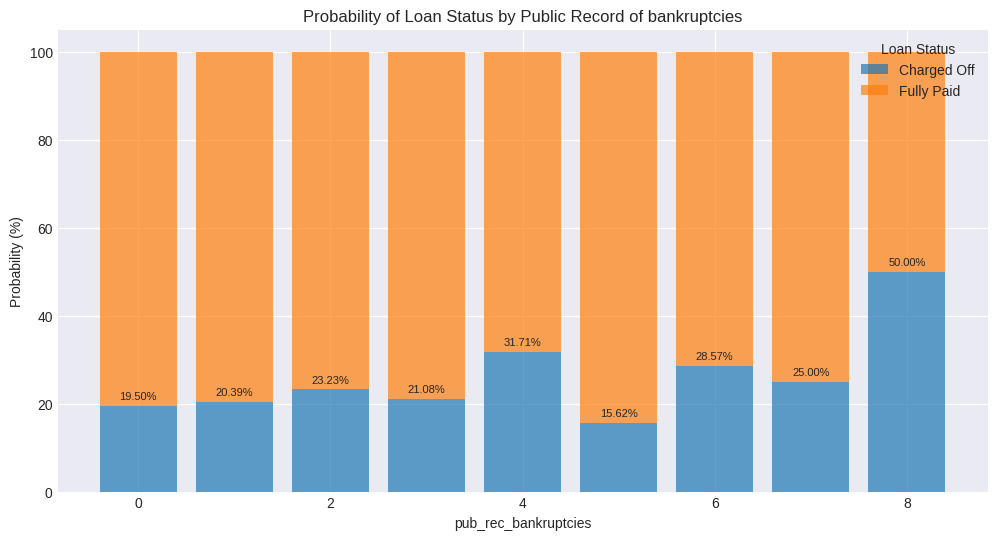

In [33]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_pub_rec_bankruptcies["Charged Off"]
fully_paid_prob = result_pub_rec_bankruptcies["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_pub_rec_bankruptcies.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_pub_rec_bankruptcies.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by Public Record of bankruptcies")
plt.xlabel("pub_rec_bankruptcies")
plt.ylabel("Probability (%)")
plt.legend(title="Loan Status", loc='upper right')
plt.show()

Above 3 Records of Public Record of Bankruptcies have higher Probability of Default

In [34]:
### Loan Status by Address
result_postal_code = (pd.crosstab(index=df["postal_code"], columns=df["loan_status"], normalize="index") * 100).round(2)
result_postal_code

loan_status,Charged Off,Fully Paid
postal_code,,
00813,0.00,100.00
05113,0.00,100.00
11650,100.00,0.00
22690,19.38,80.62
29597,0.00,100.00
30723,19.49,80.51
48052,20.02,79.98
70466,19.56,80.44
86630,100.00,0.00


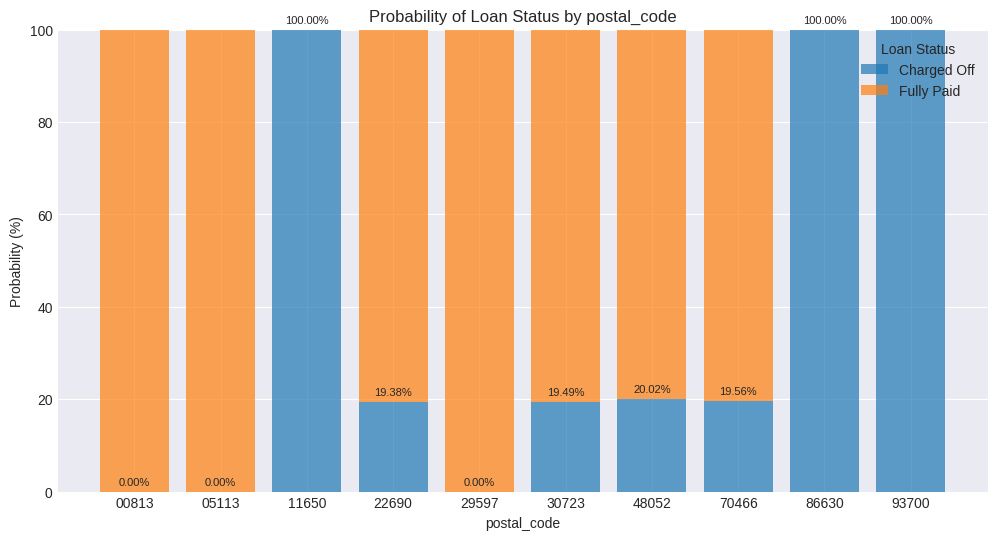

In [35]:

# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_postal_code["Charged Off"]
fully_paid_prob = result_postal_code["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_postal_code.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_postal_code.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by postal_code")
plt.xlabel("postal_code")
plt.ylabel("Probability (%)")
# plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()

Postal Code 11650, 86630, 93700 have 100% probability of Default

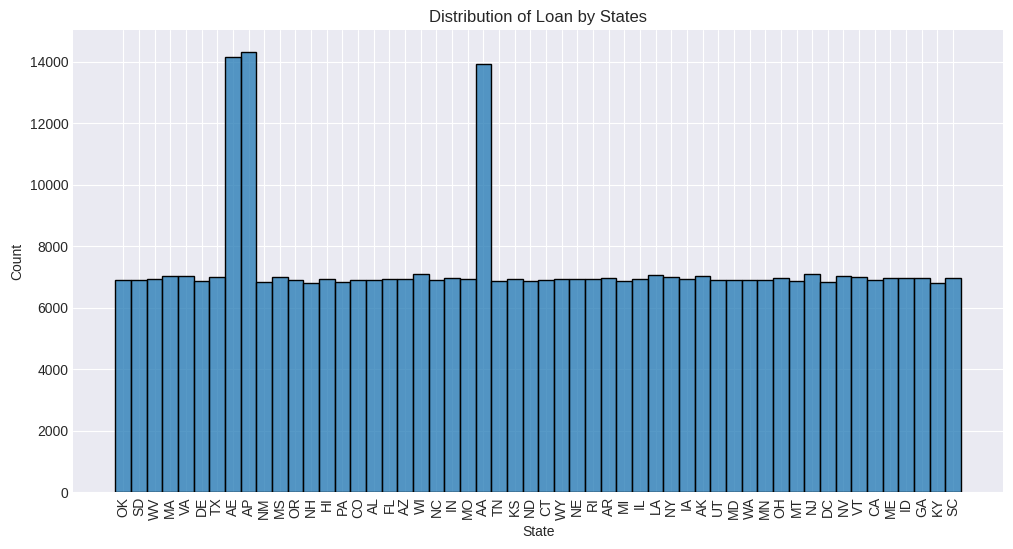

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(df["State"])
plt.title("Distribution of Loan by States")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [37]:
result_state = (pd.crosstab(index=df["State"], columns=df["loan_status"], normalize="index") * 100).round(2)
result_state[:20]

loan_status,Charged Off,Fully Paid
State,,
AA,19.48,80.52
AE,19.52,80.48
AK,19.76,80.24
AL,19.54,80.46
AP,20.08,79.92
AR,19.82,80.18
AZ,19.66,80.34
CA,19.05,80.95
CO,19.47,80.53


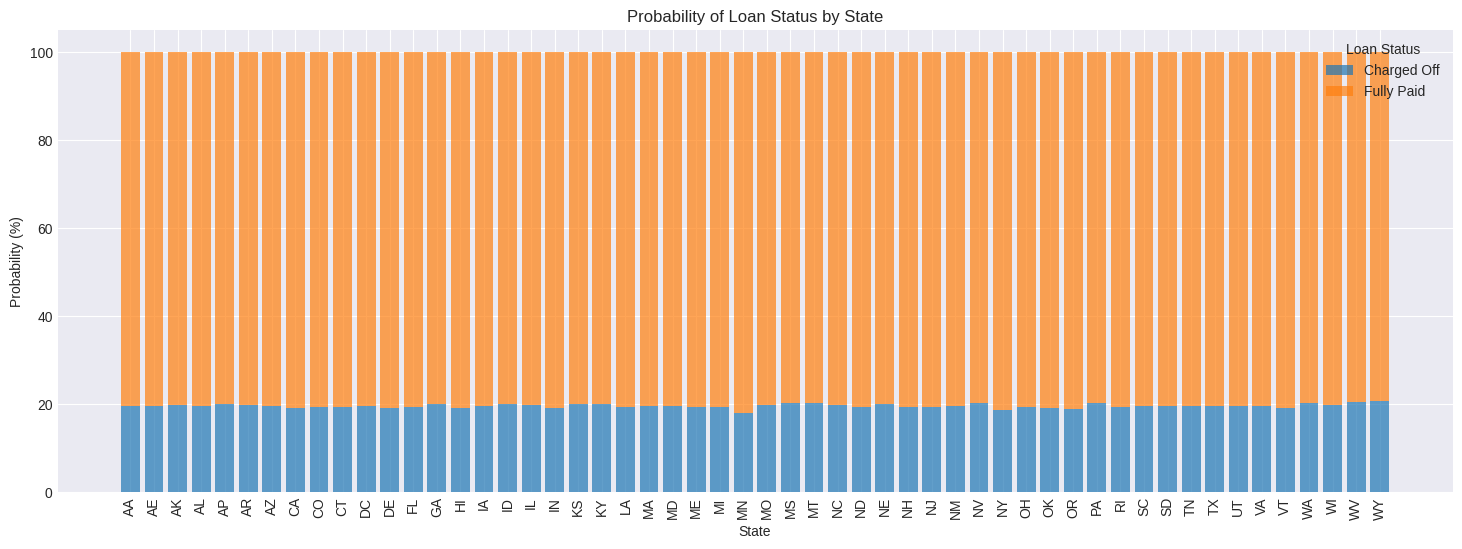

In [38]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_state["Charged Off"]
fully_paid_prob = result_state["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(18, 6))
bars_charged_off = plt.bar(result_state.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label

plt.bar(result_state.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by State")
plt.xlabel("State")
plt.ylabel("Probability (%)")
plt.xticks(rotation=90)
plt.legend(title="Loan Status", loc='upper right')
plt.show()

States has overall same probability of Loan_status as fully paid and defaulter.

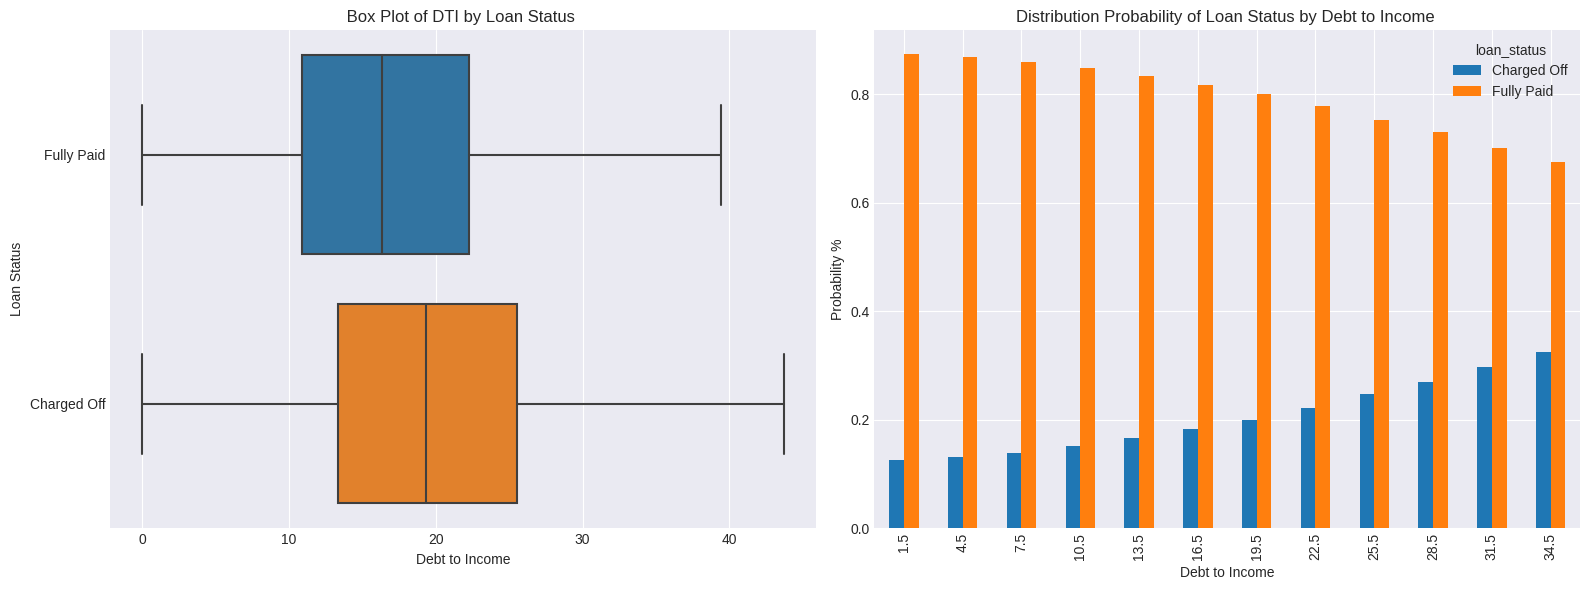

In [39]:
#DTI Impact on Loan Status (Outliers Suppressed) by Showlfliers for Boxplot and 99% max value for barPlot for eda
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="dti"
sns.boxplot(data=df, y="loan_status", x=item, showfliers=False, ax=axes[0])
axes[0].set_title(" Box Plot of DTI by Loan Status  ")
axes[0].set_ylabel("Loan Status")
axes[0].set_xlabel("Debt to Income")

bins = pd.interval_range(start=round(df[item].min()), end=round(df[item].quantile(.99)), freq=3)
pd.crosstab(index=pd.cut(df[item], bins=bins).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[1])
axes[1].set_title("Distribution Probability of Loan Status by Debt to Income ")
axes[1].set_ylabel("Probability %")
axes[1].set_xlabel("Debt to Income")
plt.tight_layout()
plt.show()

Debt to Income ratio is higher for defaulters.

In [40]:
df["home_ownership"].value_counts(dropna=False)

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [41]:
df["home_ownership"] = df["home_ownership"].replace({"NONE":"OTHER", "ANY":"OTHER"})

In [42]:
result_home_ownership = (pd.crosstab(index=df["home_ownership"], columns=df["loan_status"], normalize="index") * 100).round(2)
result_home_ownership

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,16.96,83.04
OTHER,15.75,84.25
OWN,20.68,79.32
RENT,22.66,77.34


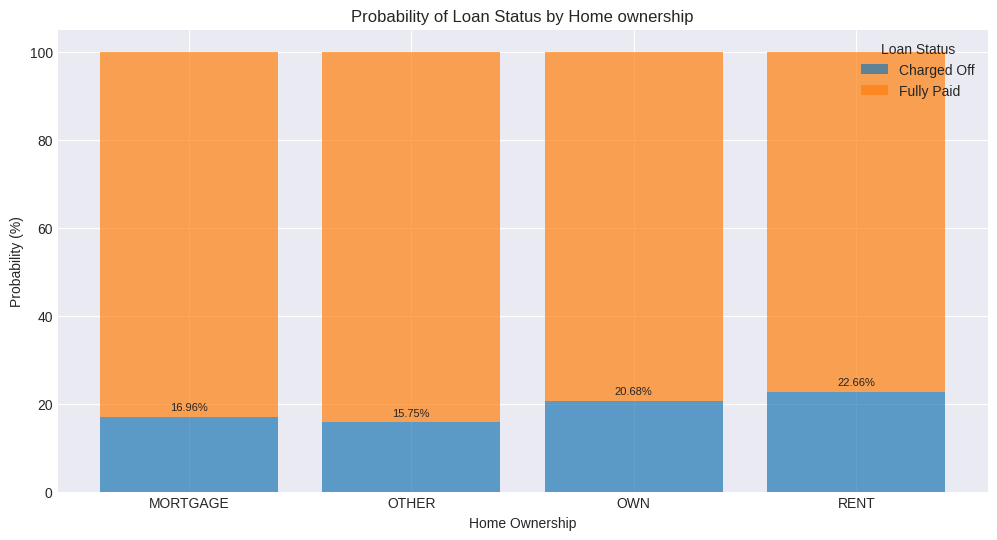

In [43]:
# Extract the probabilities for "Charged Off" and "Fully Paid"
charged_off_prob = result_home_ownership["Charged Off"]
fully_paid_prob = result_home_ownership["Fully Paid"]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars_charged_off = plt.bar(result_home_ownership.index, charged_off_prob, alpha=0.7, label="Charged Off")  # Add label
# Annotate the bars with the "Charged Off" values
for bar, value in zip(bars_charged_off, charged_off_prob):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, f"{value:.2f}%", ha="center", va="bottom", fontsize=8)

plt.bar(result_home_ownership.index, fully_paid_prob, bottom=charged_off_prob, label="Fully Paid", alpha=0.7)
plt.title("Probability of Loan Status by Home ownership")
plt.xlabel("Home Ownership")
plt.ylabel("Probability (%)")
plt.legend(title="Loan Status", loc='upper right')
plt.show()

Rent has higher Probabitly of Default for Home Ownership

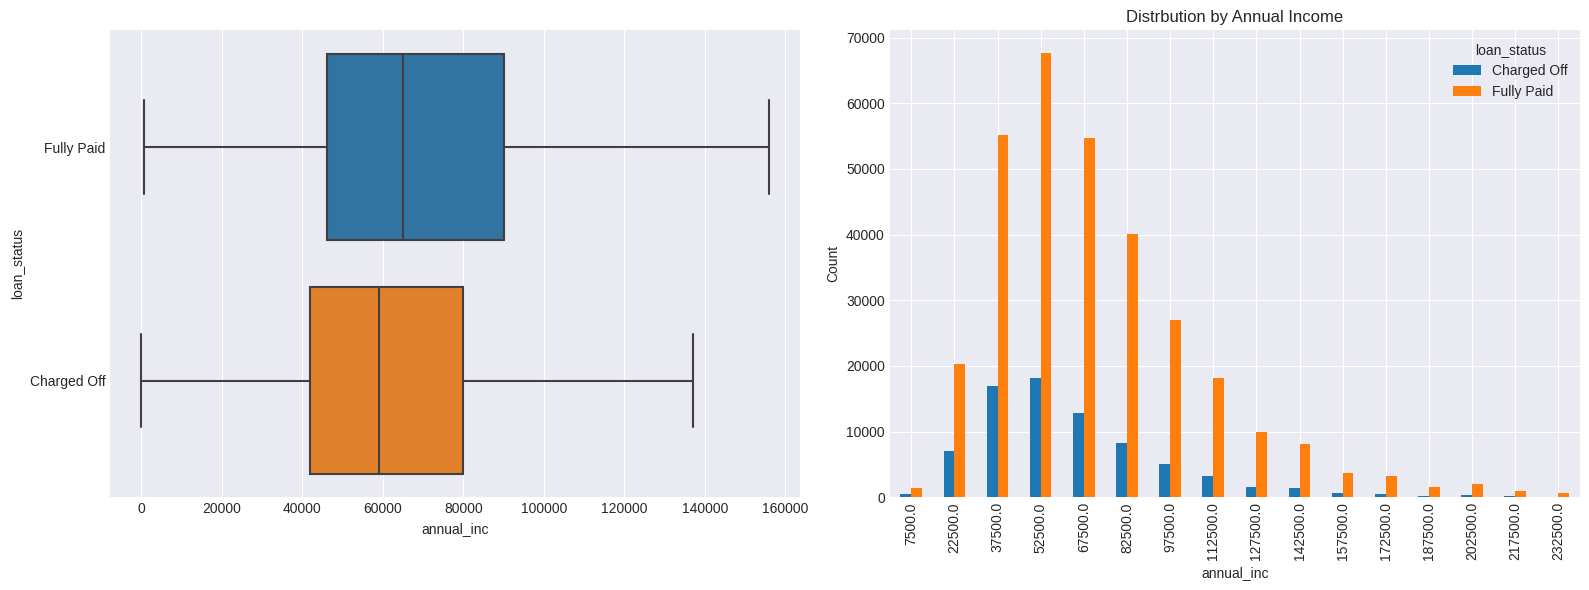

In [44]:
#Annual Income (Outliers Suppressed) by Showlfliers for Boxplot and 99% max value for barPlot
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="annual_inc"
sns.boxplot(data=df, y="loan_status", x=item, showfliers=False,ax=axes[0])

bins = pd.interval_range(start=round(df[item].min()), end=round(df[item].quantile(.99)), freq=15000)
pd.crosstab(index=pd.cut(df[item], bins=bins).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"]).plot(kind="bar", ax=axes[1])
axes[1].set_title("Distrbution by Annual Income")
axes[1].set_ylabel("Count")

plt.tight_layout()

# plt.title("Loan Status by "+ item )
plt.show()

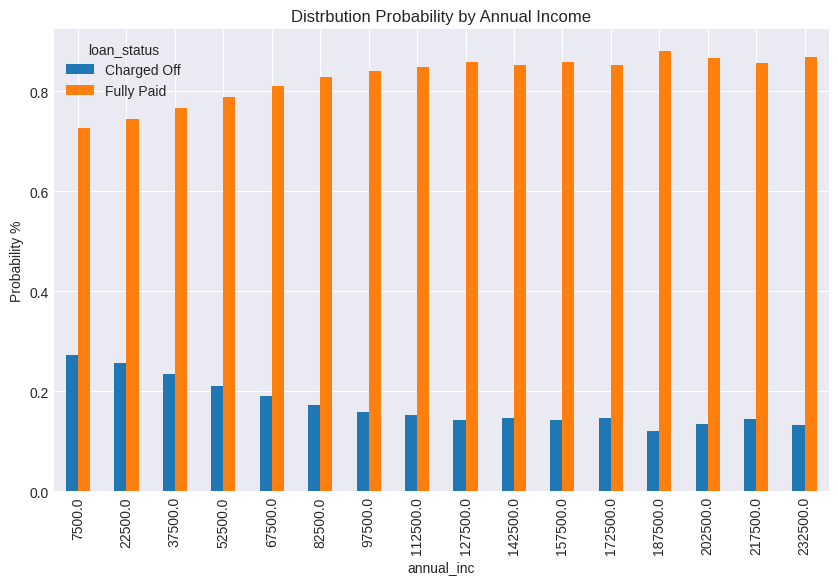

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.crosstab(index=pd.cut(df[item], bins=bins).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize='index').plot(kind="bar", ax=ax)
ax.set_title("Distrbution Probability by Annual Income")
ax.set_ylabel("Probability %")
plt.show()

Low Annual Income has Proability of Deafulter, i.e less than 50000

<Axes: xlabel='initial_list_status', ylabel='count'>

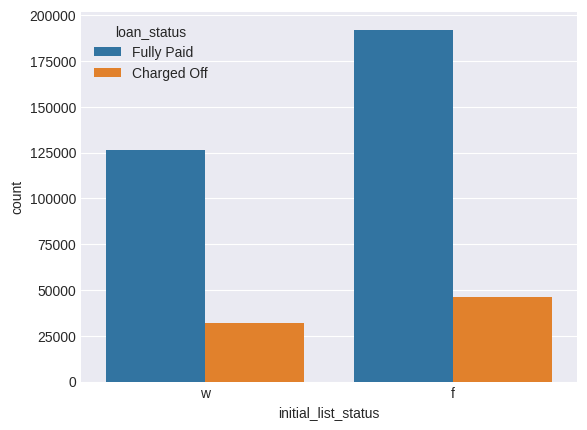

In [46]:
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

<Axes: xlabel='application_type', ylabel='count'>

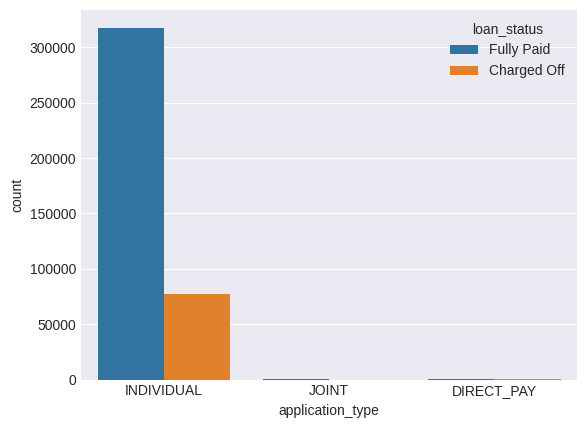

In [47]:
sns.countplot(x='application_type',data=df,hue='loan_status')

In [48]:
## outlier Treatment
for col in num_cols:
    mean=df[col].mean()
    std=df[col].std()

    upper_limit=mean+3*std
    lower_limit=mean-3*std

    df=df[(df[col]<upper_limit) & (df[col]>lower_limit)]

df.shape



(327265, 29)

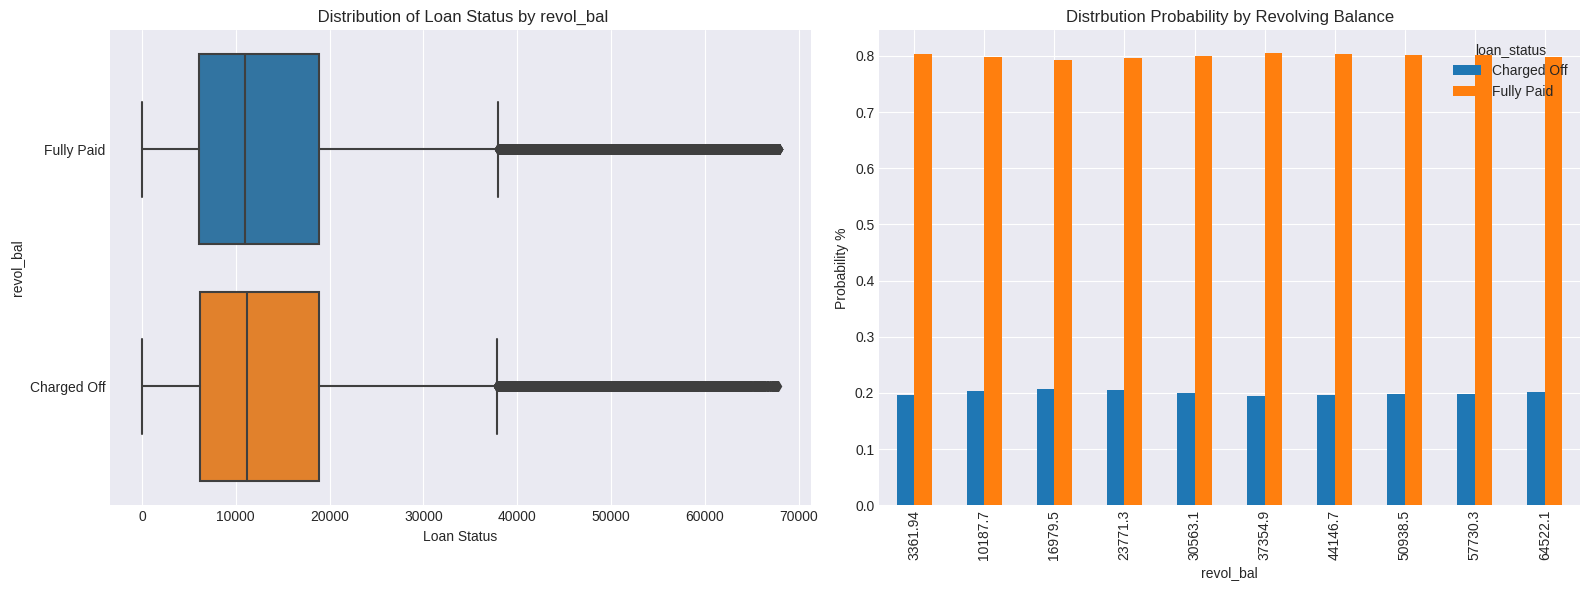

In [49]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="revol_bal"
sns.boxplot(data=df, y="loan_status", x=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)

pd.crosstab(index=pd.cut(df[item], bins=10).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[1])
axes[1].set_title("Distrbution Probability by Revolving Balance")
axes[1].set_ylabel("Probability %")
# Adjust the layout
plt.tight_layout()

# plt.title("Loan Status by "+ item )
plt.show()

Revol bal has No impact on Loan Status

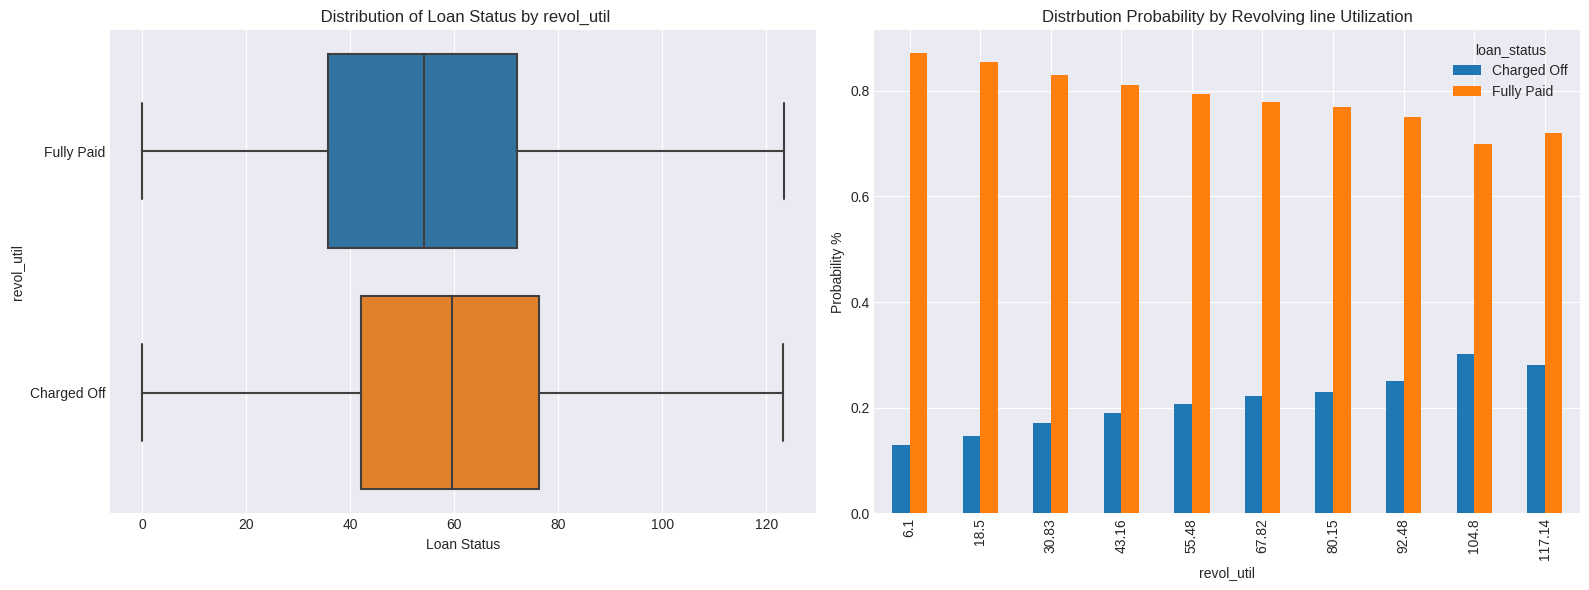

In [50]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="revol_util"
sns.boxplot(data=df, y="loan_status", x=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)

pd.crosstab(index=pd.cut(df[item], bins=10).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[1])
axes[1].set_title("Distrbution Probability by Revolving line Utilization")
axes[1].set_ylabel("Probability %")
plt.tight_layout()

# plt.title("Loan Status by "+ item )
plt.show()

Higher Revolving line utilization rate in Charged Off loans, more default probailty above ~50% utiization rate

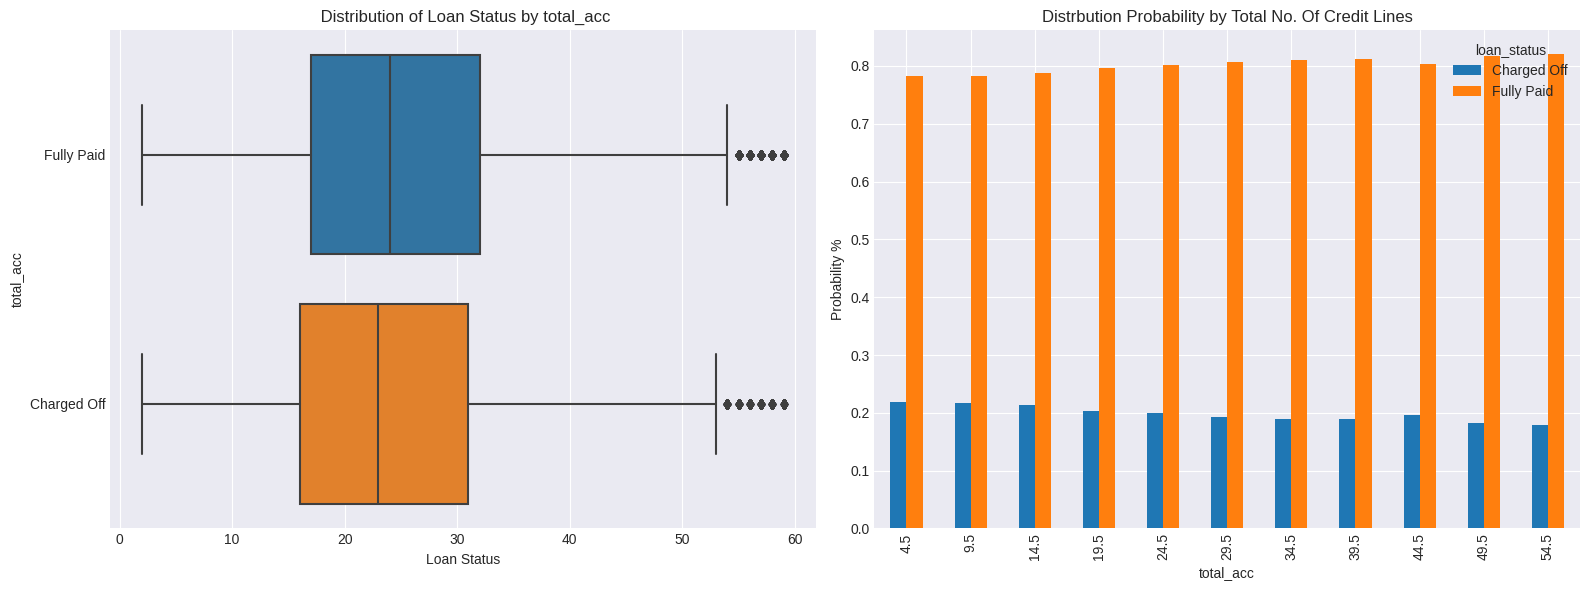

In [51]:
fig, axes = plt.subplots(1,2, figsize=(16,6))
item="total_acc"
sns.boxplot(data=df, y="loan_status", x=item, ax=axes[0])
axes[0].set_title(" Distribution of Loan Status by "+ item )
axes[0].set_xlabel("Loan Status")
axes[0].set_ylabel(item)

bins = pd.interval_range(start=round(df[item].min()), end=round(df[item].max()), freq=5)
pd.crosstab(index=pd.cut(df[item], bins=bins).apply(lambda x: round(x.mid, 2)), columns=df["loan_status"], normalize="index").plot(kind="bar", ax=axes[1])
axes[1].set_title("Distrbution Probability by Total No. Of Credit Lines")
axes[1].set_ylabel("Probability %")
plt.tight_layout()

# plt.title("Loan Status by "+ item )
plt.show()

Total number of credit lines have no impact on Loan Status

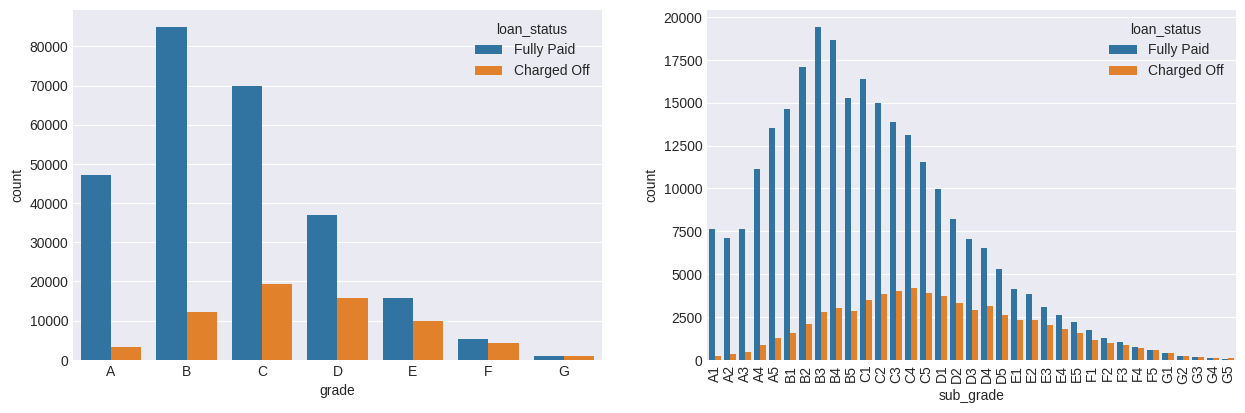

In [54]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

probability default increases with grade is E,F,G

<ipython-input-55-afc23c0a59b2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='spearman')


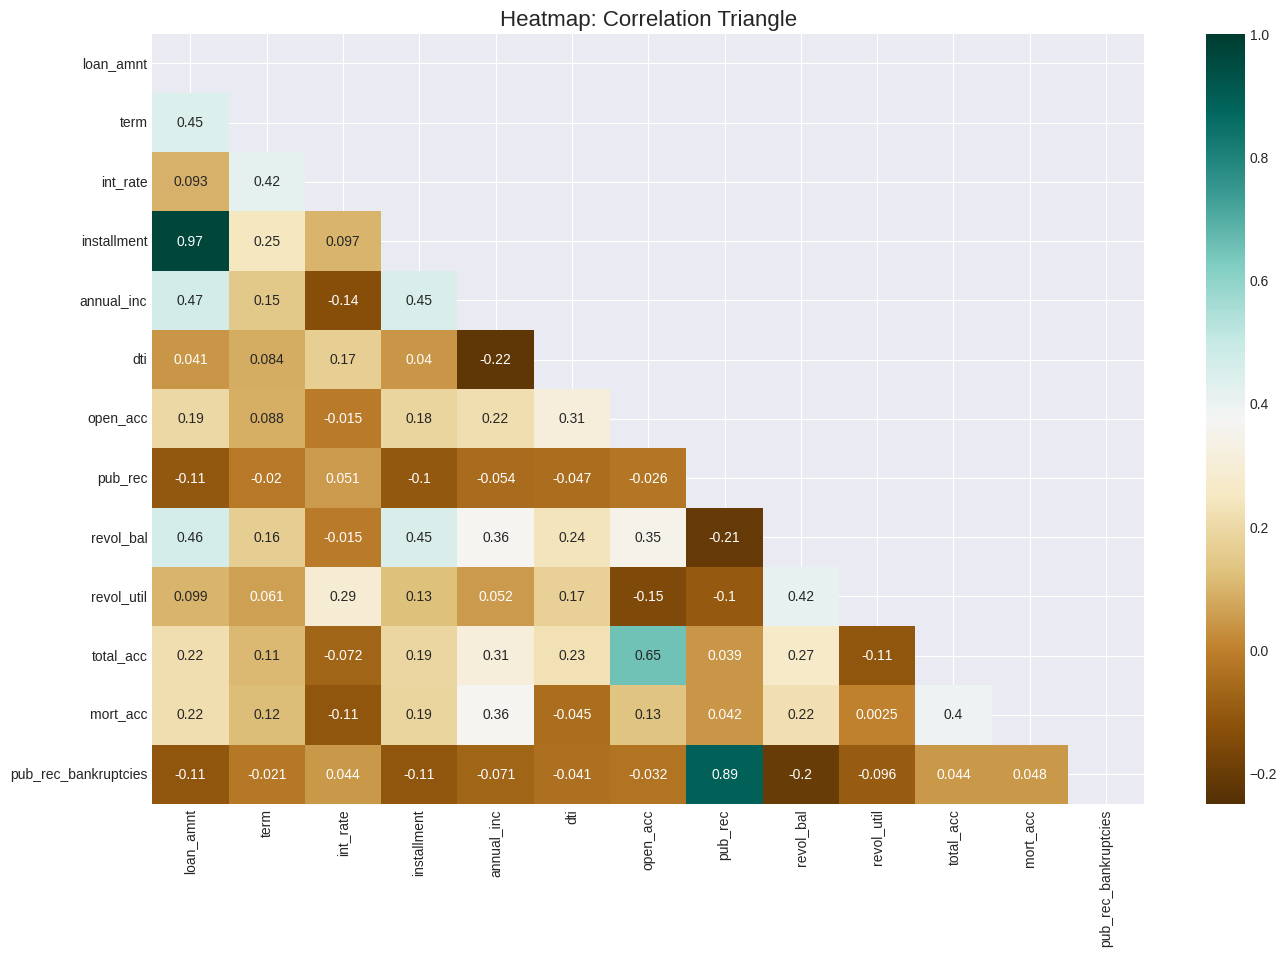

In [55]:
corr = df.corr(method='spearman')
plt.figure(figsize=((16,10)))
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
heatmap = sns.heatmap(corr, mask=mask, vmin=-.25, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Heatmap: Correlation Triangle',fontdict={'fontsize':16})
plt.show()

## Data Pre Processing

In [56]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'City', 'State', 'postal_code'],
      dtype='object')

In [57]:
# Drop rows with missing values
# df.dropna(inplace=True)
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy="most_frequent")
df["mort_acc"] = Imputer.fit_transform(df["mort_acc"].values.reshape(-1,1))
df["emp_title"] = Imputer.fit_transform(df["emp_title"].values.reshape(-1,1))
df["emp_length"] = Imputer.fit_transform(df["emp_length"].values.reshape(-1,1))
df["pub_rec_bankruptcies"] = Imputer.fit_transform(df["pub_rec_bankruptcies"].values.reshape(-1,1))
df["revol_util"] = Imputer.fit_transform(df["revol_util"].values.reshape(-1,1))

df.drop(["title","issue_d","earliest_cr_line","initial_list_status"],axis = 1, inplace=True)

### Target Encoding

In [58]:
!pip install category_encoders --quiet

In [59]:
from category_encoders import TargetEncoder

In [60]:
df["loan_status"].replace({"Fully Paid":0,
                          "Charged Off" : 1},inplace=True)

In [61]:
cat_cols=df.dtypes=="object"
cat_cols= list(cat_cols[cat_cols].index)
cat_cols

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type',
 'City',
 'State',
 'postal_code']

In [62]:
TE = TargetEncoder()
df[cat_cols] = TE.fit_transform(df[cat_cols],df["loan_status"])

In [63]:
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,City,State,postal_code
0,10000.0,36,11.44,329.48,0.126582,0.139270,0.246812,0.199064,0.233539,117000.0,0.148151,0,0.194962,26.24,16.0,0.0,36369.0,41.8,25.0,0.201445,0.0,0.0,0.195776,0.197245,0.198416
1,8000.0,36,11.99,265.68,0.126582,0.158623,0.221823,0.200506,0.173284,65000.0,0.148151,0,0.211883,22.05,17.0,0.0,20131.0,53.3,27.0,0.201445,3.0,0.0,0.246017,0.199965,0.000000
2,15600.0,36,10.49,506.97,0.126582,0.124387,0.178890,0.215084,0.233539,43057.0,0.223220,0,0.171563,12.79,13.0,0.0,11987.0,92.2,26.0,0.201445,0.0,0.0,0.177281,0.206807,0.000000
3,7200.0,36,6.49,220.65,0.063608,0.049104,0.175241,0.196255,0.233539,54000.0,0.148151,0,0.171563,2.60,6.0,0.0,5472.0,21.5,13.0,0.201445,0.0,0.0,0.172875,0.200103,0.000000
4,24375.0,60,17.27,609.33,0.217325,0.252607,0.305349,0.206444,0.173284,55000.0,0.229857,1,0.171563,33.95,13.0,0.0,24584.0,69.8,43.0,0.201445,1.0,0.0,0.305349,0.201660,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396024,6000.0,36,13.11,202.49,0.126582,0.139270,0.175241,0.199042,0.233539,64000.0,0.148151,0,0.211883,10.81,7.0,0.0,11456.0,97.1,9.0,0.201445,0.0,0.0,0.130109,0.198994,0.000000
396025,10000.0,60,10.99,217.38,0.126582,0.139270,0.175241,0.199362,0.233539,40000.0,0.223220,0,0.211883,15.63,6.0,0.0,1990.0,34.3,23.0,0.201445,0.0,0.0,0.195776,0.200280,0.199313
396026,21000.0,36,12.29,700.42,0.217325,0.176346,0.216049,0.199042,0.173284,110000.0,0.223220,0,0.211883,21.45,6.0,0.0,43263.0,95.7,8.0,0.201445,1.0,0.0,0.200173,0.201822,0.000000
396027,5000.0,36,9.99,161.32,0.126582,0.098280,0.284586,0.199064,0.233539,56500.0,0.229857,0,0.211883,17.56,15.0,0.0,32704.0,66.9,23.0,0.201445,0.0,0.0,0.205999,0.190476,0.201516


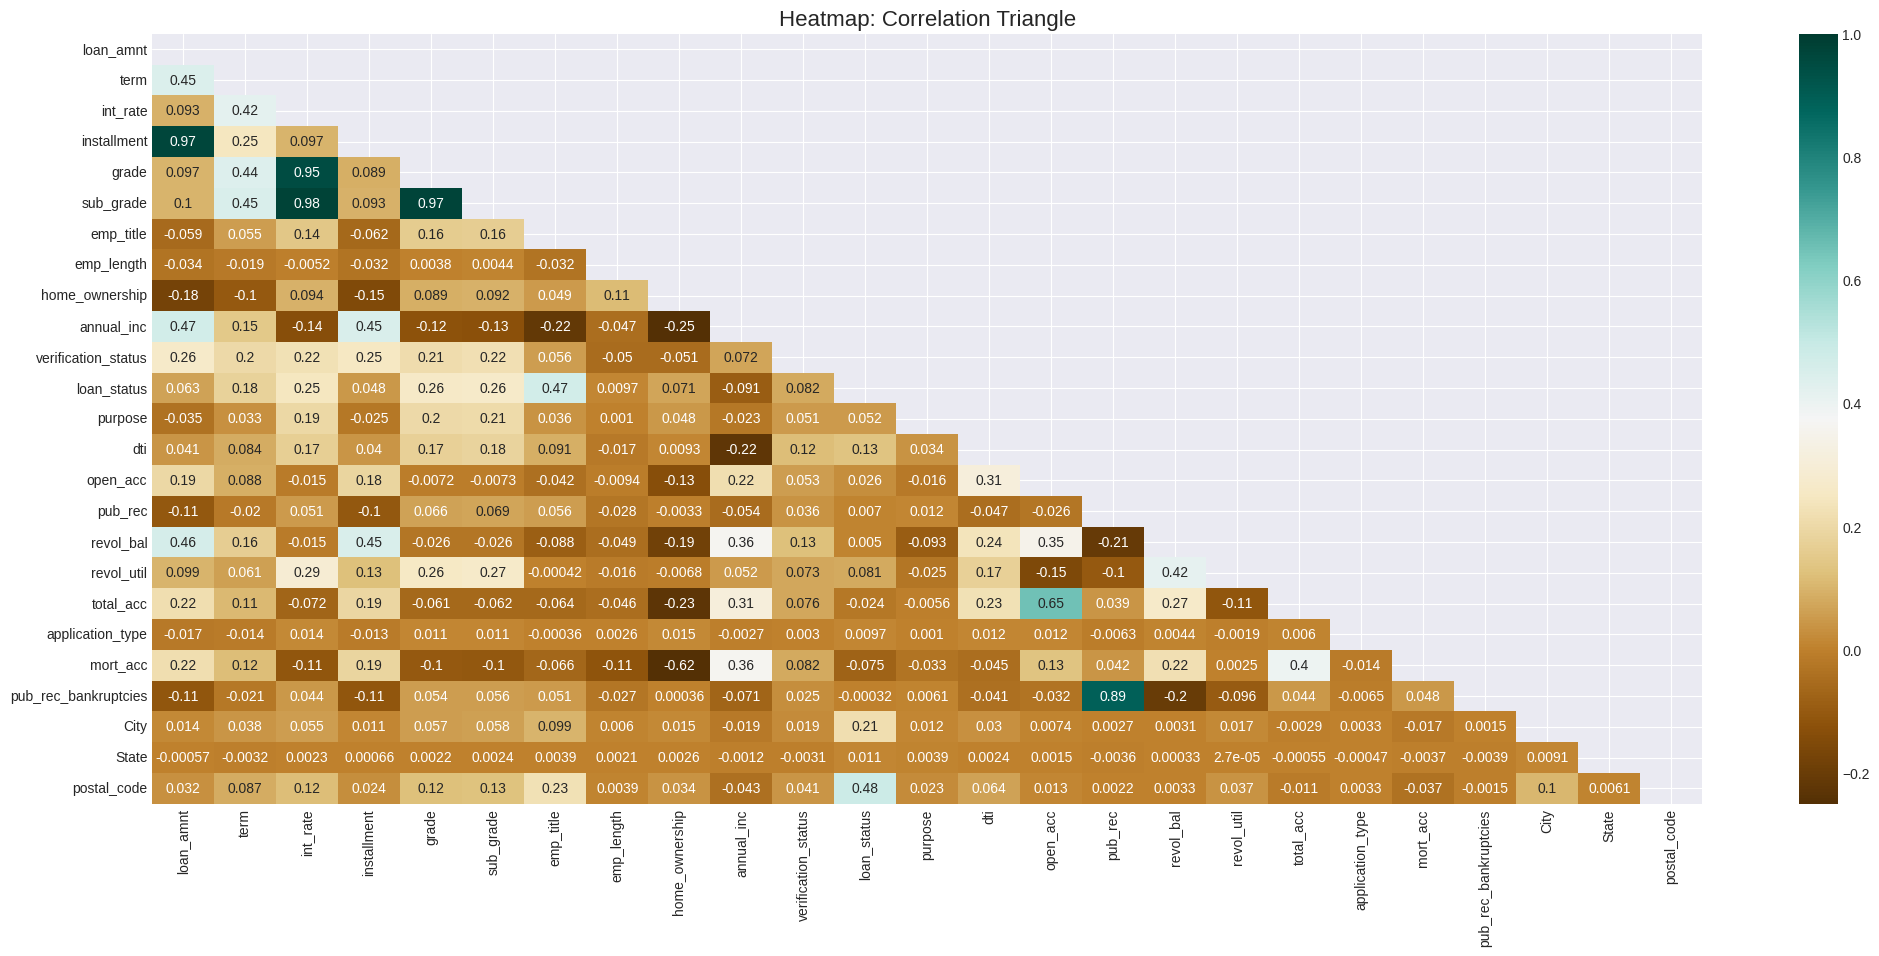

In [64]:
corr = df.corr(method='spearman')
plt.figure(figsize=((25,10)))
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
heatmap = sns.heatmap(corr, mask=mask, vmin=-.25, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Heatmap: Correlation Triangle',fontdict={'fontsize':16})
plt.show()

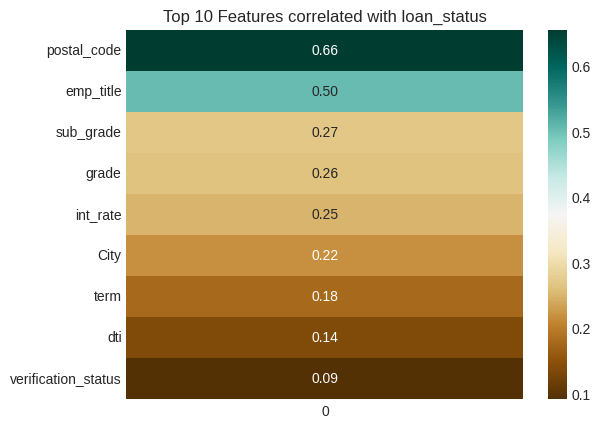

In [65]:
corr_matrix = df.corrwith(df['loan_status'])
sorted_corr_matrix = corr_matrix.abs().sort_values(ascending=False)
sorted_corr_matrix =sorted_corr_matrix.iloc[1:10]
sns.heatmap(sorted_corr_matrix.to_frame(), cmap="BrBG", annot=True, fmt=".2f")
plt.title("Top 10 Features correlated with loan_status")
plt.show()

In [66]:
find_missing_values(df,False)

,Column,Count,Percentage


In [67]:
# df.dropna(inplace=True)

In [68]:
X = df.drop(["loan_status"],axis = 1)
y = df["loan_status"]

### Train test Split | Scaling

In [69]:
from sklearn.model_selection import train_test_split

X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25,random_state=1)
X_train.shape,y_train.shape

((196359, 24), (196359,))

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

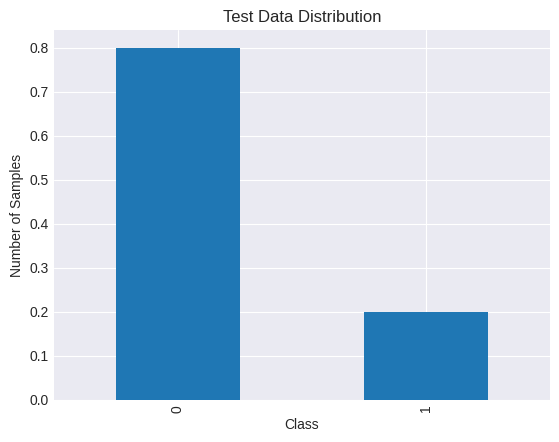

In [71]:
y_test.value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

**Imbalance Data**

## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight={0:1,1:4})  ##Imbalance Data, Fully Paid 0, Charged off 1
model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 4})

In [73]:
print('Train Model Accuracy :',model.score(X_train,y_train).round(3))
print('Val Model Accuracy Val:',model.score(X_val,y_val).round(3))
print('Val Model Accuracy Val:',model.score(X_test,y_test).round(3))

Train Model Accuracy : 0.893
Val Model Accuracy Val: 0.891
Val Model Accuracy Val: 0.893


In [74]:
from sklearn.metrics import f1_score,recall_score,precision_score

In [75]:
y_pred =model.predict(X_test)
print('Test F1 Score:',f1_score(y_test,y_pred).round(2))

Test F1 Score: 0.77


In [76]:
feature_importance = pd.DataFrame(data=model.coef_,columns=X.columns).T.round(3).sort_values(by=0, axis=0, ascending=False).reset_index()
feature_importance

,index,0
0,postal_code,9.827
1,emp_title,1.391
2,sub_grade,0.840
3,City,0.548
4,term,0.225
5,open_acc,0.172
6,dti,0.170
7,revol_util,0.166
8,home_ownership,0.123
9,installment,0.072


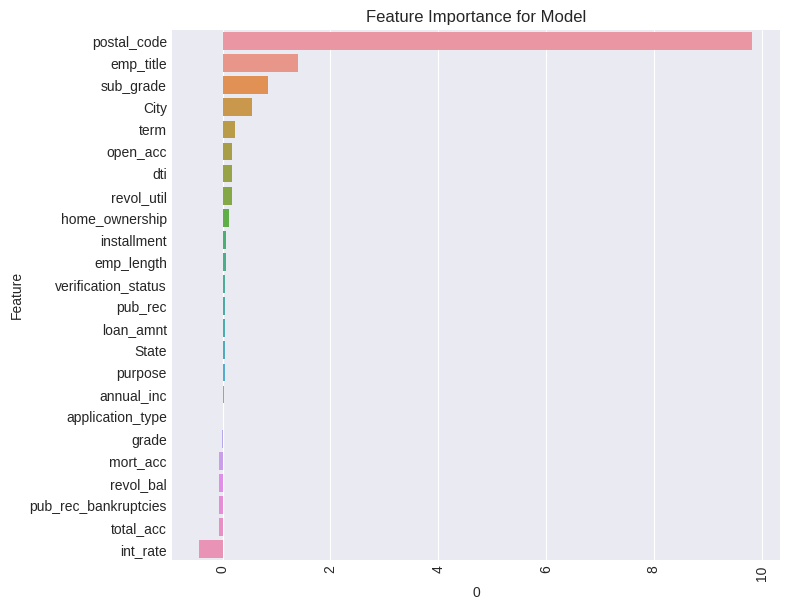

In [77]:
plt.figure(figsize=(8,6))
sns.barplot(y = feature_importance["index"],
           x =  feature_importance[0])
plt.xticks(rotation =90)
plt.tight_layout()
plt.title("Feature Importance for Model")
plt.ylabel("Feature")
plt.show()

#### Confusion Matrix

In [78]:

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,precision_recall_curve
)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[46831,  5500],
       [ 1490, 11632]])

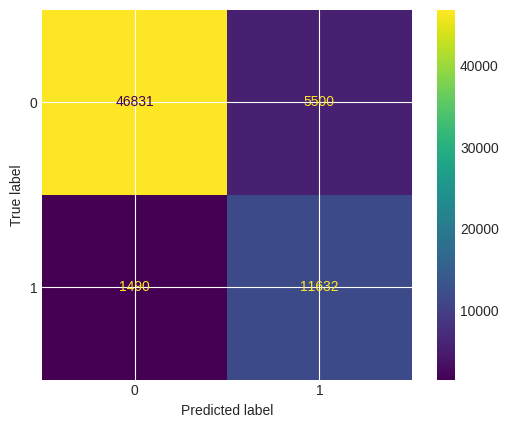

In [79]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [80]:
print("True Postive %: ", round(conf_matrix[0,0] / conf_matrix.sum(),2))
print("False Postive %: ", round(conf_matrix[0,1] / conf_matrix.sum(),2))
print("False Negative %: ", round(conf_matrix[1,0] / conf_matrix.sum(),2))
print("False Negative %: ", round(conf_matrix[1,1] / conf_matrix.sum(),2))

True Postive %:  0.72
False Postive %:  0.08
False Negative %:  0.02
False Negative %:  0.18


In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     52331
           1       0.68      0.89      0.77     13122

    accuracy                           0.89     65453
   macro avg       0.82      0.89      0.85     65453
weighted avg       0.91      0.89      0.90     65453



In [82]:
probability = model.predict_proba(X_test)
probability

array([[9.99960697e-01, 3.93025877e-05],
       [4.46324870e-01, 5.53675130e-01],
       [9.99843566e-01, 1.56434050e-04],
       ...,
       [7.57224974e-02, 9.24277503e-01],
       [6.32827124e-14, 1.00000000e+00],
       [8.83642544e-01, 1.16357456e-01]])

In [83]:
probabilites = probability[:,1]

### ROC Curve

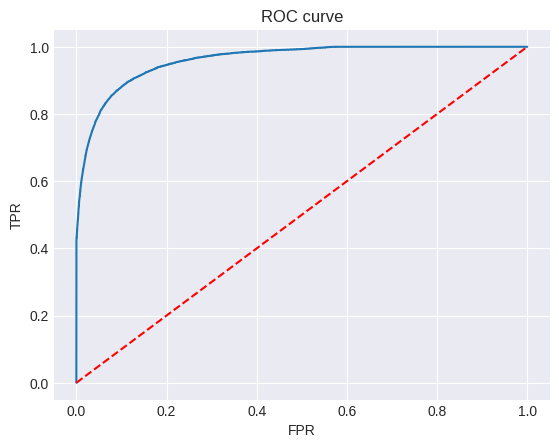

In [84]:
fpr, tpr, thr = roc_curve(y_test,probabilites)
plt.plot(fpr,tpr)

#random model
plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [85]:
roc_auc_score(y_test,probabilites)

0.9609860488160243

We get an AU-ROC value of 96%
showing that the model is performing very good

But our F1 Score was just 89%
which made us believe our model was a decent one

### Precision Recall Curve

In [86]:
precision, recall, thr = precision_recall_curve(y_test, probabilites)

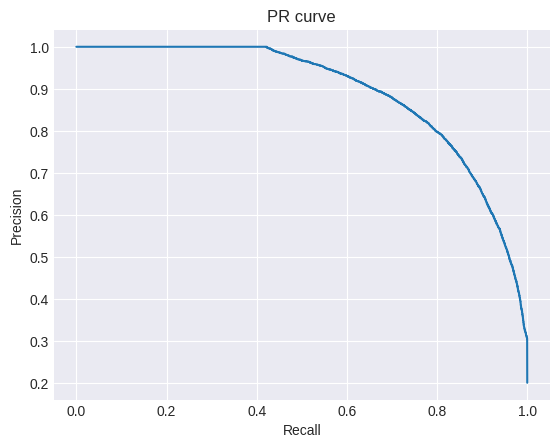

In [87]:
plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show()

In [88]:
auc(recall, precision)

0.8930733228032182

AU-PRC comes close to F1 score

Showing that PRC worked just fine in imbalanced data